# Group 5

*   Hanna Merkle
*   Jesse König
*   Philipp Bauer

## Task 1: Homework Review
Groups 1 and 42

Tutor: Leon Lemke

## Task 2: Learning a policy via 1-step SARSA

For the following work again work with your own gridworld implementation!
You may revise/change pieces of it, or ask other groups for access to their
implementation of course.

*   Implement tabular 1-step SARSA control
*   Measure average Return-per-Episode and plot it against (1) episodes sampled, and (2) wallclock-time


For an outstanding submission:

*   Visualize the State-Action Values in your gridworld during training at
regular intervals, and provide a visualization of them (e.g. a series of
images, best combine them into a short video clip)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ACTIONS = ["LEFT", "RIGHT", "UP", "DOWN"]

class GridWorld:
  def __init__(self, shape, start, goal, goal_reward = 2, step_punishment = -0.01):
    # initialize empty grid
    self.shape = shape
    self.grid = np.ndarray(shape, dtype=GridTile)
    for i in range(shape[0]):
      for j in range(shape[1]):
        self.grid[i,j]=GridTile((i,j), reward = step_punishment)

    # list of all states as coordinates (x,y)
    self.states = [state for state in np.ndindex(*self.shape)]
    
    # put agent on start tile
    self.start = start
    self.grid[start].has_agent = True
    self.agent_pos = start
    
    # set goal tile
    self.grid[goal].is_goal = True
    self.grid[goal].reward = goal_reward
    self.goal = goal
    self.goal_reward = goal_reward

    # list of tuples (state, action, reward) updated in state_transition function
    self.trajectory = []

  # setter method
  def move_agent(self, target_tile):
    self.grid[self.agent_pos].has_agent = False
    self.agent_pos = target_tile.position
    target_tile.has_agent = True

  def get_target(self, position, action):
    # get current coordinates
    agent_x, agent_y = position

    # target = which tile would the agent like to go to?
    if action == "LEFT":
      target = (agent_x, agent_y-1)
    elif action == "RIGHT":
      target = (agent_x, agent_y+1)
    elif action == "UP":
      target = (agent_x-1, agent_y)
    elif action == "DOWN":
      target = (agent_x+1, agent_y)
    elif action == None:
      target = (agent_x, agent_y)

    return target

  # changes state according to action of agent
  def state_transition(self, action):
    old_pos = self.agent_pos
    target = self.get_target(old_pos, action)
    
    # if target is out of bounds stay put
    if target[0] < 0 or target[1] < 0 or target[0] > self.shape[0]-1 or target[1] > self.shape[1]-1:
      target_tile = self.grid[self.agent_pos]
    else:
      target_tile = self.grid[target]

    # reward (from effect tile)
    r = 0

    if action == None:
      target_tile = self.grid[self.agent_pos]
      self.move_agent(target_tile)

    # check tile types
    elif not target_tile.passable:
      # stay where you are
      target_tile = self.grid[self.agent_pos]
      self.move_agent(target_tile)

    elif target_tile.effect == 'ice':
      # move to ice tile
      self.move_agent(target_tile)
      # slide one tile further if that is a valid move
      if self.valid_move(self.agent_pos, action):
        r = self.state_transition(action)
      
    elif target_tile.effect == 'wind':
      # move to wind tile
      self.move_agent(target_tile)
      # blown off in random direction
      r = self.state_transition(np.random.choice(ACTIONS))

    # standard move, i.e. tile without special effect
    else:
      self.move_agent(target_tile)
    
    # reward from tile + potential effect
    reward = target_tile.reward + r

    # update trajectory
    state = old_pos

    self.trajectory.append((state, action, reward))

    # 
    return reward

  # check whether given move can be made
  def valid_move(self, position, action):
    # can't move any where from wall (doesn't happen anyways, just used for visualizing policy)
    if not self.grid[position].passable:
      return False

    # can't move from goal
    if position == self.goal:
      return False

    target = self.get_target(position, action)

    if target[0] < 0 or target[1] < 0 or target[0] > self.shape[0]-1 or target[1] > self.shape[1]-1:
      return False
    else:
      target_tile = self.grid[target]

    # can't move into wall
    if not target_tile.passable:
      return False

    # else/finally -> no checks failed, move is valid
    return True

  # return list of all possible moves for a given position
  def valid_moves(self, position):
    moves = [action for action in ACTIONS if self.valid_move(position, action)]
    if len(moves) > 0:
      return moves
    else:
      return [None]

  # optional task
  def __str__(self):
    return '\n'.join([''.join([str(item) for item in row]) for row in self.grid]) + '\n'

class GridTile:
  def __init__(self,position=(0,0),reward=0,passable=True,effect=None,has_agent=False,is_goal=False):
    self.position = position
    self.reward = reward
    self.passable = passable
    self.effect = effect
    self.has_agent = has_agent
    self.is_goal = is_goal

  # optional task
  def __str__(self):
    if self.passable==False: return '⛔'
    if self.has_agent==True: return '🤖'
    if self.is_goal==True: return '🟩'
    e = self.effect
    if e == None: return '⬜'
    if e == 'ice': return '🧊'
    if e == 'wind': return '🌪️'

class GridAgent:
  def __init__(self, gw):
    self.reward = 0

    # choose a random action valid action
    def rand_action(state):
      possible_actions = gw.valid_moves(state)
      #print(state, possible_actions)
      return np.random.choice(possible_actions)

    # initial policy is random
    self.policy = {state: (rand_action(state) if (gw.grid[state].passable and not state==gw.goal) else None) for state in gw.states}

In [ ]:
# set up example GridWorld
def gw_constructor(exploring_starts = True, step_punishment = -0.01):
  # choose random starting state (exclude walls, goal)
  if exploring_starts:
    exclude = {(2,2),(1,2), (4,4)}
    all_states = {(i,j) for i in range(5) for j in range(5)}
    options = list(all_states - exclude)
    start = options[np.random.randint(len(options))]
  else:
    start = (0,0)

  gw = GridWorld((5,5), start, (4,4), step_punishment = step_punishment)

  # set effect/wall tiles
  gw.grid[3,1].effect = 'wind'
  gw.grid[3,1].reward = -0.5

  gw.grid[1,4].effect = 'ice'
  
  gw.grid[2,2].passable = False
  gw.grid[1,2].passable = False

  return gw

# string representation of a policy
def policy_repr(policy, goal):
  policy_rep = ''
  row = 0
  for state, action in policy.items():
    if state[0] > row:
      row += 1
      policy_rep += "\n"
    if action == "LEFT":
        policy_rep += "⬅️"
    elif action == "RIGHT":
        policy_rep += "➡️"
    elif action == "UP":
        policy_rep += "⬆️"
    elif action == "DOWN":
        policy_rep += "⬇️"
    elif state == goal:
        policy_rep += "🟩"
    else:
        policy_rep += "⛔"
  return policy_rep

In [ ]:
def greedy_q(q_values,s):
  # get q value for each action in given state s
  state_actions_q = {action : q_values[state,action] for state, action in q_values.keys() if state==s}
  # sort q values, [-1] to get last item (highest value), [0] to get action from that item (a,q)
  return sorted(state_actions_q.items(), key=lambda item: item[1])[-1][0]

In [ ]:
from time import perf_counter

In [ ]:
def sarsa(gw, agent, n_episodes, alpha, gamma, exploring_starts = False, track_q=((0,0), "RIGHT")):
  start = perf_counter()
  episodic_returns = []
  timed_returns = {}
  q_values = {(state, action): 0 for state in gw.states for action in gw.valid_moves(state)}

  q_changes = {}

  for episode in range(n_episodes):

    q_changes.update({episode: q_values[track_q]})

    s = gw.agent_pos
    a = greedy_q(q_values, s)

    while not gw.grid[gw.agent_pos].is_goal:
      r = gw.state_transition(a)
      agent.reward += r
      s2 = gw.agent_pos
      a2 = greedy_q(q_values, s2)

      q_values[(s,a)] = q_values[(s,a)] + alpha*(r + gamma*q_values[(s2,a2)]-q_values[(s,a)])
      
      agent.policy[s] = greedy_q(q_values,s)
      
      s = s2
      a = a2

    episodic_returns.append(agent.reward)
    timed_returns.update({perf_counter()-start: agent.reward})

    gw = gw_constructor(exploring_starts)
    agent.reward = 0

  return q_values, agent.policy, episodic_returns, timed_returns, q_changes

GridWorld Layout
🤖⬜⬜⬜⬜
⬜⬜⛔⬜🧊
⬜⬜⛔⬜⬜
⬜🌪️⬜⬜⬜
⬜⬜⬜⬜🟩

Final policy
➡️➡️➡️➡️⬇️
⬇️⬆️⛔➡️⬇️
⬇️⬆️⛔⬇️⬇️
⬇️⬇️⬅️➡️⬇️
➡️➡️➡️➡️🟩 



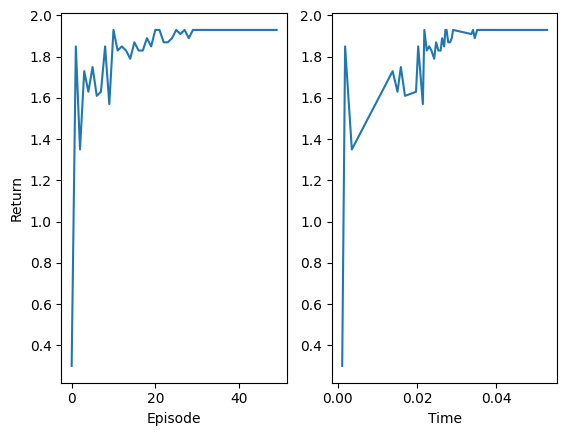

In [ ]:
gw = gw_constructor(exploring_starts=False)
agent = GridAgent(gw)
print("GridWorld Layout")
print(gw)

q_values, policy, e_returns, t_returns, _ = sarsa(gw,agent,50,0.1,0.9, False)

print("Final policy")
print(policy_repr(policy, gw.goal), "\n")

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(e_returns)
ax1.set(xlabel = 'Episode', ylabel = 'Return')
ax2.plot(t_returns.keys(), t_returns.values())
ax2.set(xlabel = 'Time')
fig.show()

## Task 3: Visiualizing Variance-Bias Trade-Off
Pick some average return, which constitures roughly the half-way-point between
your algorithms average starting return and fully trained return. For both MCcontrol (from last weeks homework) and 1-step SARSA, do the following: (pick
the same state for both!)

*  For both SARSA and MC-Control:
    *  Sample 1000 or more episodes starting at some specific (e.g. the starting) state, with some specific action
    *  Update only this specific starting Q-value!
    *  Track how the Q-value changes over the episodes (i.e. provide a list or ndarray with an estimation over each episode)

*  Repeat the above 100 (or more) times for both SARSA and MC-Control
*  For both SARSA and MC-Control, create a lineplot including mean and std 
   estimation (over the 100+ repeats) vs. episodes sampled
*  Interpret the result

GridWorld Layout (Start position randomized)
⬜⬜⬜⬜⬜
⬜⬜⛔⬜🧊
⬜⬜⛔⬜⬜
🤖🌪️⬜⬜⬜
⬜⬜⬜⬜🟩

Final policy
➡️➡️➡️➡️⬇️
⬇️⬆️⛔➡️⬇️
⬇️⬅️⛔➡️⬇️
⬇️➡️➡️➡️⬇️
➡️➡️➡️➡️🟩 



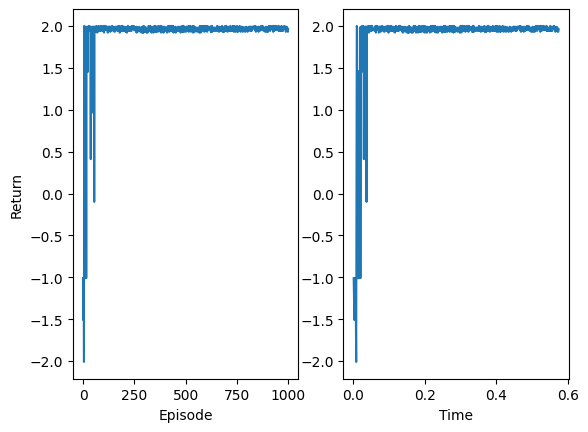

In [ ]:
# code copied from HW2N

# max steps avoid infinite run/running in circles
def run(gw, agent, max_steps=500):
  steps = 0

  while not gw.grid[gw.agent_pos].is_goal:
    # choose action according to policy
    action = agent.policy[gw.agent_pos]

    # perform action and get reward
    r = gw.state_transition(action)    
    agent.reward += r

    steps += 1
    # quit early
    if steps > max_steps:
      return agent.reward

  # if we start in goal state no action is required
  if gw.start == gw.goal:
    gw.trajectory.append((gw.start, None, gw.goal_reward))
    return gw.goal_reward
  
  # return -> cumulated agent reward
  return agent.reward

def policy_iteration(max_episodes = 1000, gamma=0.9, track_q = ((0,0),"RIGHT")):
  # initialization
  start = perf_counter()
  gw = gw_constructor()
  # has random policy at start
  agent = GridAgent(gw)

  # q=0 for all states and action
  q_values = {(state, action): 0 for state in gw.states for action in gw.valid_moves(state)}
  # empty returns
  returns = {(state, action): [] for state in gw.states for action in gw.valid_moves(state)}

  # for plotting
  episodic_returns = []
  timed_returns = {}

  #### NEW PART
  q_changes = {}
  ###


  n_episodes = 0
  while True:
    ### NEW PART: Track changes in Q((0,0), RIGHT)
    q_changes.update({n_episodes: q_values[track_q]})
    ###

    n_episodes += 1

    # s_0 determined by constructor, just choose a_0
    if gw.start != gw.goal:
      a_0 = np.random.choice(gw.valid_moves(gw.agent_pos))
    else:
      a_0 = None

    # perfrom first action a_0
    gw.state_transition(a_0)
    
    # run through normal policy after first action (start state for policy is reset)
    gw.start = gw.agent_pos
    rt = run(gw, agent, 100)
    
    # plotting
    episodic_returns.append(rt)
    timed_returns.update({perf_counter()-start: rt})

    G = 0
    for s, a, r in gw.trajectory[::-1]:
      G = gamma*G + r
      
      # remove current (s,a,r) from trajectory
      gw.trajectory.pop()

      # check if (s,a) has been repeated
      if not (s,a) in [(s_,a_) for s_,a_,r_ in gw.trajectory]:
        returns[(s,a)].append(G)
        q_values[(s,a)] = np.average(returns[(s,a)])

        # get q value for each action in given state s
        state_actions_q = {action : q_values[(state,action)] for state, action in q_values.keys() if state==s}
        # sort q values, [-1] to get last item (highest value), [0] to get action from that item (a,q)
        argmax_a = sorted(state_actions_q.items(), key=lambda item: item[1])[-1][0]
        # update policy for state s
        agent.policy[s] = argmax_a
    
    # reset for new episode
    gw = gw_constructor()
    agent.reward = 0

    # return final policy and values for plotting
    if n_episodes == max_episodes:
      return q_values, agent.policy, episodic_returns, timed_returns, q_changes

_, policy, e_returns, t_returns, _ = policy_iteration(1000)

gw = gw_constructor()
print("GridWorld Layout (Start position randomized)")
print(gw)
print("Final policy")
print(policy_repr(policy, gw.goal), "\n")

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(e_returns)
ax1.set(xlabel = 'Episode', ylabel = 'Return')
ax2.plot(t_returns.keys(), t_returns.values())
ax2.set(xlabel = 'Time')
fig.show()

In [ ]:
iter_q_ch = []
sarsa_q_ch = []
track_q = (0,0), "RIGHT"

for i in range(100):
  iter_q_values, iter_policy, iter_e_returns, iter_t_returns, iter_q_changes = policy_iteration(1000, track_q=track_q)
  iter_q_ch.append(iter_q_changes)
  sarsa_q_values, sarsa_policy, sarsa_e_returns, sarsa_t_returns, sarsa_q_changes = sarsa(gw,agent,1000,0.1,0.9, False, track_q=track_q)
  sarsa_q_ch.append(sarsa_q_changes)

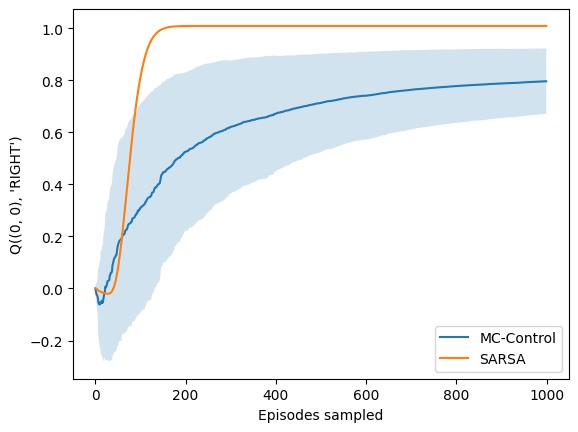

In [ ]:
fig, ax = plt.subplots()
iter_mean = [np.mean([item[i] for item in iter_q_ch]) for i in range(1000)]
iter_std = [np.std([item[i] for item in iter_q_ch]) for i in range(1000)]
sarsa_mean = [np.mean([item[i] for item in sarsa_q_ch]) for i in range(1000)]
sarsa_std = [np.std([item[i] for item in sarsa_q_ch]) for i in range(1000)]
ax.set(ylabel=f'Q{track_q}', xlabel="Episodes sampled")
ax.plot(iter_mean, label='MC-Control')
ax.fill_between(np.arange(1000),np.array(iter_mean)-np.array(iter_std), np.array(iter_mean)+np.array(iter_std), alpha=0.2)
ax.plot(sarsa_mean, label="SARSA")
ax.fill_between(np.arange(1000),np.array(sarsa_mean)-np.array(sarsa_std), np.array(sarsa_mean)+np.array(sarsa_std), alpha=0.9)
ax.legend(loc='lower right')

The plot shows that the mean Q values obtained with the 1-step SARSA algorithm are higher compared to those achieved with MC-Control. Additionally, the MC-Control algorithm has a high standard deviation in its Q-values.

The difference in the plot can be attributed to the update processes from the two algorithms. In 1-step SARSA, only the current and next time steps are considered when updating the Q-values. At every time step, the Q-values are directly updated based on the observed reward and the estimated value of the next state-action pair. This immediate update leads to less variance in the Q-values, resulting in a more stable learning process and faster convergence towards optimal values.

MC-Control requires a full return, which is the cumulative reward obtained from the current state-action pair until the end of the episode. So, the returns can only be calculated for each state-action pair after a complete episode has finished. This delayed update contributes to the high variance observed in the Q-values when using the MC-Control algorithm. 

However, due to the bootstrapping in SARSA-1 step with the estimations for 1-step ahead, the bias is also higher compared to MC-control. This bias arises because the estimated values may not perfectly match the true values. This bias may have led to the high mean Q-values.

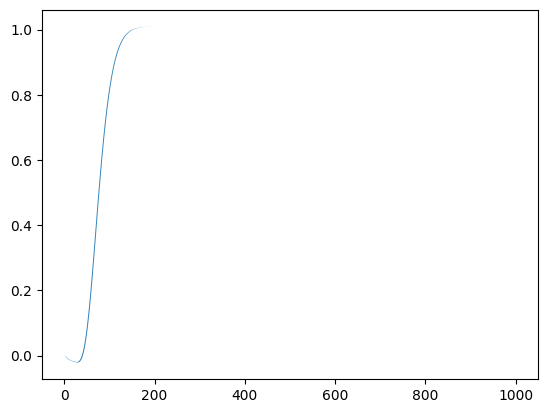

In [ ]:
# sarsa std not really visible in plot above
plt.fill_between(np.arange(1000),np.array(sarsa_mean)-np.array(sarsa_std), np.array(sarsa_mean)+np.array(sarsa_std), alpha=0.9)